In [2]:
import numpy as np
import scipy.sparse as sps
import h5py
from termcolor import colored

def decode_str(hdf5_str):
    return hdf5_str.tobytes().decode('utf-16')

# filename = 'Head-and-Neck/Head-and-Neck_01.mat'
# filename = 'Prostate_CK/Prostate_CK_10.mat'
filename = 'Liver/Liver_01.mat'

f = h5py.File(filename)
print(colored('Patient: ' + decode_str(f['patient']['Identifier'][:]), 'blue'))

Patient: Liver 01


In [3]:
class Region:
    def __init__(self, name):
        self.name = name    
        self.D = None # Dose deposition matrix (called A in TROTS)

    def compute_dose(self, x):
        self.dose = self.D.dot(x)
        self.min = self.dose.min()
        self.mean = self.dose.mean()
        self.max = self.dose.max()

def load_rois():
    print('Loading dose deposition matrices...')
    
    rois = {}
    for ref in f['patient']['StructureNames'][:]:
        name = decode_str(f[ref[0]][:])
        rois[name] = Region(name)

    # Get the dose matrix for each ROI
    n_mats = f['data']['matrix']['A'].shape[0]
    for i in range(n_mats):
        name = decode_str(f[f['data']['matrix']['Name'][i,0]][:])

        if name in rois:
            roi = rois[name]
            A = f[f['data']['matrix']['A'][i,0]]
            
            if isinstance(A, h5py.Group): # It's a sparse matrix
                data = np.array(A['data']).ravel()
                ir = np.array(A['ir']).ravel()
                jc = np.array(A['jc']).ravel()
                n_voxels = A.attrs.get('MATLAB_sparse')
                n_beamlets = jc.size - 1
                shape = (n_voxels, n_beamlets)
                
                roi.D = sps.csc_matrix((data, ir, jc), shape=shape)
                
                print(colored(f'  {name} -> {shape} (sparse)', 'green'))
            elif isinstance(A, h5py.Dataset): # It's a dense matrix
                roi.D = A[:].T
                shape = roi.D.shape
                print(colored(f'  {name} -> {shape} (dense)', 'green'))
            else:
                print(colored(f'  {name} -> Not processed!', 'magenta'))
        else:
            print(colored(f'  {name} -> Ignored', 'yellow'))

    # Check that all regions have dose matrices
    for name, roi in rois.items():
        if roi.D is None:
            print(colored(f'  {name} -> No dose matrix!', 'red'))
    
    return rois

rois = load_rois()

Loading dose deposition matrices...
  Isocentre -> (1, 1118) (dense)
  PTV -> (5364, 1118) (dense)
  Stomach -> (5209, 1118) (sparse)
  Spinal Cord -> (5152, 1118) (sparse)
  Heart -> (5151, 1118) (sparse)
  Oesophagus -> (2991, 1118) (sparse)
  Duodenum -> (5094, 1118) (sparse)
  Pancreas -> (5183, 1118) (sparse)
  External Ring -> (4794, 1118) (sparse)
  Liver minus CTV -> (5117, 1118) (sparse)
  Kidney (R) -> (5269, 1118) (sparse)
  Kidney (L) -> (5263, 1118) (sparse)
  Isocentre -> (1, 1118) (dense)
  Liver minus CTV (mean) -> Ignored
  Oesophagus (mean) -> Ignored
  Duodenum (mean) -> Ignored
  Stomach (mean) -> Ignored
  Heart (mean) -> Ignored
  Spinal Cord (mean) -> Ignored
  Pancreas (mean) -> Ignored
  Kidney (R) (mean) -> Ignored
  Kidney (L) (mean) -> Ignored
  Patient (mean) -> Ignored
  Patient -> (25957, 1118) (sparse)
  Smoothing Linear -> Ignored
  Smoothing Quadratic -> Ignored
  Sm2 beam 1 -> Ignored
  Sm2 beam 2 -> Ignored
  Sm2 beam 3 -> Ignored
  Sm2 beam 4 -> Ign

In [4]:
def compute_dose(fluence):
    for name, roi in rois.items():
        roi.compute_dose(fluence)

def dose_table():
    print(colored('Patient: ' + decode_str(f['patient']['Identifier'][:]), 'blue'))
    print()
    print(colored('{:30s} {:>9s} {:>9s} {:>9s}'.format('Region of Interest', 'Min.', 'Mean', 'Max.'), attrs=["bold"]))
    print(colored('-'*60, 'blue'))

    for name, roi in rois.items():
        print('{:30s} {:9.2f} {:9.2f} {:9.2f}'.format(name, roi.min, roi.mean, roi.max))

solutionX = f['solutionX'][:].ravel()
compute_dose(solutionX)
dose_table()



Patient: Liver 01

Region of Interest                  Min.      Mean      Max.
------------------------------------------------------------
PTV                               -24.75    -11.21     -0.00
Stomach                             0.00      3.93     18.82
Oesophagus                          0.00      3.17     18.19
Heart                               0.00      5.00     27.00
Duodenum                            0.00      3.58     19.00
Kidney (R)                          0.00      5.39     35.32
Kidney (L)                          0.00      0.17      2.75
Spinal Cord                         0.00      0.73      8.51
Liver minus CTV                     0.00      9.37     73.53
Pancreas                            0.00      5.00     17.64
Patient                             0.00      1.29     55.58
Isocentre                          75.00     75.00     75.00
External Ring                       0.00      0.72     21.00
PTV40%                              0.00      6.88     13.91
PTV80

In [5]:
from enum import Enum
from dataclasses import dataclass

class CostFunction(Enum):
    Linear = 1
    Quadratic = 2
    gEUD = 3
    LTCP = 4
    DVH = 5
    Chain = 6

class Function:
    def __init__(self, name, type, is_constraint, is_minimize, target, is_scalar, priority, parameters):
        self.name = name
        self.type = CostFunction(type)
        self.minimum = None
        self.mean = None
        self.maximum = None
        self.target = target
        self.priority = priority

        if is_constraint:
            self.kind = 'Constraint'
        else:
            self.kind = 'Objective'

        if self.type == CostFunction.Linear:
            if self.kind == 'Objective':
                if is_scalar and is_minimize:
                    self.direction = 'mean'
                else:
                    self.direction = 'maximum'
            else:
                self.direction = 'maximum' if is_minimize else 'minimum'
        elif self.type == CostFunction.LTCP or self.type == CostFunction.gEUD:
            self.parameters = [x[0] for x in parameters]
            self.direction = ''
        else:
            self.direction = ''

    def __repr__(self):
        return '{:30s} {} {:16s} {:>3d} {:8.2f}'.format(self.name, 
            colored('Const.', 'yellow') if self.kind == 'Constraint' else colored('Objec.', 'cyan'), 
            (self.type.name + ' (' + self.direction + ')') if self.direction != '' else self.type.name,
            self.priority, self.target)

def load_problem():
    functions = []
    
    print(colored('Patient: ' + decode_str(f['patient']['Identifier'][:]), 'blue'))
    print()
    print(colored('Region of Interest             Kind   Function         Pr.   Target  Current', attrs=["bold"]))
    print(colored('----------------------------------------------------------------------------', 'blue'))
    
    for i in range(f['problem']['dataID'].shape[0]):
        name = decode_str(f[f['problem']['Name'][i][:][0]][:])
        type = f[f['problem']['Type'][i][0]][0][0]
        is_constraint = f[f['problem']['IsConstraint'][i][0]][0][0] == 1
        is_minimize = f[f['problem']['Minimise'][i][0]][0][0] == 1
        target = f[f['problem']['Objective'][i][0]][0][0]
        dataID = int(f[f['problem']['dataID'][i][0]][0][0]) - 1
        is_scalar = isinstance(f[f['data']['matrix']['A'][dataID,0]], h5py.Dataset)
        #is_sufficient = isinstance(f[f['problem']['Sufficient'][i][0]][0], np.ndarray)
        priority = int(f[f['problem']['Priority'][i][0]][0][0])
        parameters = f[f['problem']['Parameters'][i][0]][:]
        
        function = Function(name, type, is_constraint, is_minimize, target, is_scalar, priority, parameters)
        print(function, end='')
        functions.append(function)
        
        if name in rois:
            roi = rois[name]
            if function.type == CostFunction.Linear:
                if function.direction == 'minimum':
                    value = roi.min
                    if value > function.target:
                        color = 'green'
                    else:
                        color = 'red'
                elif function.direction == 'mean':
                    value = roi.mean
                    if value < function.target:
                        color = 'green'
                    else:
                        color = 'red'
                else:
                    value = roi.max
                    if value < function.target:
                        color = 'green'
                    else:
                        color = 'red'
                print(colored(' {:8.2f}'.format(value), color))
            elif function.type == CostFunction.LTCP:
                p1 = function.parameters[0]
                p2 = function.parameters[1]
                value = np.sum(np.exp(-p2*(roi.dose - p1))/len(roi.dose))
                if value < function.target*1.01: # 0.1% allowance for rounding errors
                    color = 'green'
                else:
                    color = 'red'
                print(colored(' {:8.2f}'.format(value), color))
            elif function.type == CostFunction.gEUD:
                p1 = function.parameters[0]
                value = (np.sum(roi.dose**p1)/len(roi.dose))**(1/p1)
                if value < function.target*1.001: # 0.1% allowance for rounding errors
                    color = 'green'
                else:
                    color = 'red'
                print(colored(' {:8.2f}'.format(value), color))
            else:
                print()
        else:
            print()

    return functions
        
functions = load_problem()

Patient: Liver 01

Region of Interest             Kind   Function         Pr.   Target  Current
----------------------------------------------------------------------------
Isocentre                      Const. Linear (maximum)   0    80.00    75.00
PTV                            Const. Linear (maximum)   0    75.00    -0.00
Stomach                        Const. Linear (maximum)   0    21.00    18.82
Spinal Cord                    Const. Linear (maximum)   0    18.00     8.51
Heart                          Const. Linear (maximum)   0    30.00    27.00
Oesophagus                     Const. Linear (maximum)   0    21.00    18.19
Duodenum                       Const. Linear (maximum)   0    21.00    19.00
Pancreas                       Const. Linear (maximum)   0    21.00    17.64
External Ring                  Const. Linear (maximum)   0    21.00    21.00
Liver minus CTV                Const. DVH                0     0.52
Kidney (R)                     Const. DVH                0     0.3

In [11]:
with open('../Results/Adam/Liver_01/x_20250824_183312.txt') as file: 
    fluence = [float(x.split()[-1]) for x in file.readlines()]
compute_dose(fluence)
functions = load_problem()

Patient: Liver 01

Region of Interest             Kind   Function         Pr.   Target  Current
----------------------------------------------------------------------------
Isocentre                      Const. Linear (maximum)   0    80.00    61.73
PTV                            Const. Linear (maximum)   0    75.00     4.43
Stomach                        Const. Linear (maximum)   0    21.00     4.89
Spinal Cord                    Const. Linear (maximum)   0    18.00     0.39
Heart                          Const. Linear (maximum)   0    30.00    19.49
Oesophagus                     Const. Linear (maximum)   0    21.00     1.35
Duodenum                       Const. Linear (maximum)   0    21.00     2.28
Pancreas                       Const. Linear (maximum)   0    21.00    17.61
External Ring                  Const. Linear (maximum)   0    21.00    13.97
Liver minus CTV                Const. DVH                0     0.52
Kidney (R)                     Const. DVH                0     0.3

In [10]:
import matplotlib.pyplot as plt

compute_dose(solutionX)

for function in functions:
    if function.type == CostFunction.LTCP:
        roi = rois[function.name]
        p1 = function.parameters[0]
        p2 = function.parameters[1]
        value = np.sum(np.exp(-p2*(roi.dose - p1))/len(roi.dose))
        print('p1', p1)
        print('p2', p2)
        print('value', value)
        
        plt.hist(roi.dose, bins=100)
        plt.title(roi.name)
        plt.xlabel('Dose (Gy)')
        plt.ylabel('Voxels')
        plt.ylim(0, 1000)
        plt.xticks(np.arange(int(roi.min), int(roi.max) + 2, 1))
        plt.grid()
        plt.show()

p1 35.0
p2 0.7
value 4.9875454721493276e-06


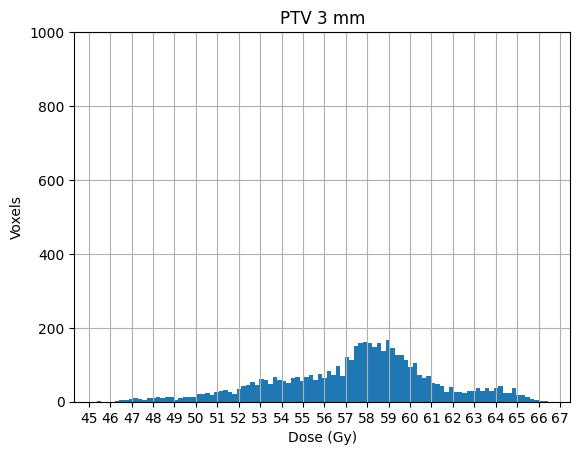

p1 58.0
p2 0.1
value 1.13199167389745


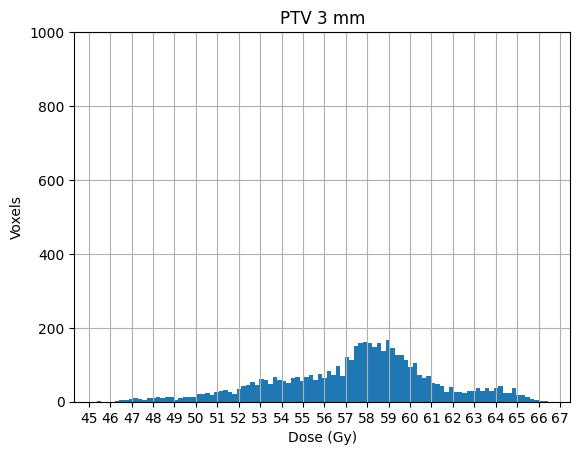

p1 45.6
p2 0.9
value 1.1628523184504269e-07


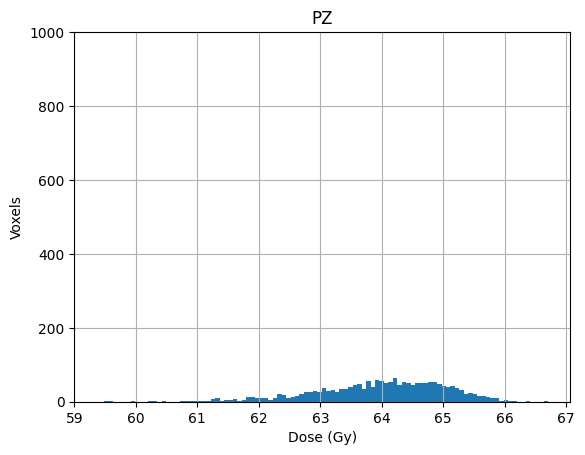

In [8]:
import matplotlib.pyplot as plt

compute_dose(fluence)

for function in functions:
    if function.type == CostFunction.LTCP:
        roi = rois[function.name]
        p1 = function.parameters[0]
        p2 = function.parameters[1]
        value = np.sum(np.exp(-p2*(roi.dose - p1))/len(roi.dose))
        print('p1', p1)
        print('p2', p2)
        print('value', value)
        
        plt.hist(roi.dose, bins=100)
        plt.title(roi.name)
        plt.xlabel('Dose (Gy)')
        plt.ylabel('Voxels')
        plt.ylim(0, 1000)
        plt.xticks(np.arange(int(roi.min), int(roi.max) + 2, 1))
        plt.grid()
        plt.show()

In [9]:
with open('../Results/Adam/Head-and-Neck_01/x_20250420_103348.txt') as file: 
    fluence = [float(x.split()[-1]) for x in file.readlines()]
compute_dose(fluence)

In [9]:
load_problem()

Patient: Prostate CK 04

Region of Interest             Kind   Function         Pr.   Target  Current
----------------------------------------------------------------------------
PTV 3 mm                       Const. Linear (maximum)   0    65.00    66.44
PZ                             Const. Linear (maximum)   0    69.16    66.71
Rectum                         Const. Linear (maximum)   0    38.00    50.87
Urethra                        Const. Linear (maximum)   0    40.00    51.97
Bladder                        Const. Linear (maximum)   0    41.80    49.88
PTV Ring 20 mm - 30 mm         Const. Linear (maximum)   0    20.00    24.33
Penis/Scrotum                  Const. Linear (maximum)   0     4.00     2.40
External Ring 20 mm            Const. Linear (maximum)   0    15.00    15.41
Penis/Scrotum                  Const. Linear (maximum)   0     2.00     2.40
PTV 7 mm                       Const. Linear (maximum)   0    45.70    48.82
PTV 3 mm                       Objec. LTCP         

[PTV 3 mm                       Const. Linear (maximum)   0    65.00,
 PZ                             Const. Linear (maximum)   0    69.16,
 Rectum                         Const. Linear (maximum)   0    38.00,
 Urethra                        Const. Linear (maximum)   0    40.00,
 Bladder                        Const. Linear (maximum)   0    41.80,
 PTV Ring 20 mm - 30 mm         Const. Linear (maximum)   0    20.00,
 Penis/Scrotum                  Const. Linear (maximum)   0     4.00,
 External Ring 20 mm            Const. Linear (maximum)   0    15.00,
 Penis/Scrotum                  Const. Linear (maximum)   0     2.00,
 PTV 7 mm                       Const. Linear (maximum)   0    45.70,
 PTV 3 mm                       Objec. LTCP               1     0.03,
 PTV 3 mm                       Objec. LTCP               2     3.10,
 Rectum                         Objec. Linear (mean)      3     0.00,
 PZ                             Objec. LTCP               4     1.00,
 Urethra            